In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#setting root dir for project
rootdir = '/content/drive/My Drive/Mask Detector/Face Mask Detection/'


In [ ]:
#setting parameters
dataset = rootdir + 'dataset'
plot = 'out.png'
model = rootdir + 'mask_detector.model'  ##DNN based face extractor
 

In [ ]:
#gathering hyperparameters
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
def _preprocess_numpy_input(x, data_format, mode):
  """Preprocesses a Numpy array encoding a batch of images.
  Arguments:
    x: Input array, 3D or 4D.
    data_format: Data format of the image array.
    mode: One of "caffe", "tf" or "torch".
      - caffe: will convert the images from RGB to BGR,
          then will zero-center each color channel with
          respect to the ImageNet dataset,
          without scaling.
      - tf: will scale pixels between -1 and 1,
          sample-wise.
      - torch: will scale pixels between 0 and 1 and then
          will normalize each channel with respect to the
          ImageNet dataset.
  Returns:
      Preprocessed Numpy array.
  """
  if not issubclass(x.dtype.type, np.floating):
    x = x.astype(backend.floatx(), copy=False)
    print('Ran x.astype')

  if mode == 'tf':
    x /= 127.5
    x -= 1.
    return x
  elif mode == 'torch':
    x /= 255.
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
  else:
    if data_format == 'channels_first':
      # 'RGB'->'BGR'
      if x.ndim == 3:
        x = x[::-1, ...]
      else:
        x = x[:, ::-1, ...]
    else:
      # 'RGB'->'BGR'
      x = x[..., ::-1]
    mean = [103.939, 116.779, 123.68]
    std = None
  print('here')
  # Zero-center by mean pixel
  if data_format == 'channels_first':
    if x.ndim == 3:
      x[0, :, :] -= mean[0]
      x[1, :, :] -= mean[1]
      x[2, :, :] -= mean[2]
      if std is not None:
        x[0, :, :] /= std[0]
        x[1, :, :] /= std[1]
        x[2, :, :] /= std[2]
    else:
      x[:, 0, :, :] -= mean[0]
      x[:, 1, :, :] -= mean[1]
      x[:, 2, :, :] -= mean[2]
      if std is not None:
        x[:, 0, :, :] /= std[0]
        x[:, 1, :, :] /= std[1]
        x[:, 2, :, :] /= std[2]
  else:
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    if std is not None:
      x[..., 0] /= std[0]
      x[..., 1] /= std[1]
      x[..., 2] /= std[2]
  return x

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset))
data = []
labels = []
i = 0;
print(len(imagePaths))
# loop over the image paths
for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  print('proessing ' + str(i))
  i = i + 1
  # load the input image (224x224) and preprocess it
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  image = _preprocess_numpy_input(image,None,'tf')
  # update the data and labels lists, respectively
  data.append(image)
  labels.append(label)

[INFO] loading images...
3846
proessing 0
proessing 1
proessing 2
proessing 3
proessing 4
proessing 5
proessing 6
proessing 7
proessing 8
proessing 9
proessing 10
proessing 11
proessing 12
proessing 13
proessing 14
proessing 15
proessing 16
proessing 17
proessing 18
proessing 19
proessing 20
proessing 21
proessing 22
proessing 23
proessing 24
proessing 25
proessing 26
proessing 27
proessing 28
proessing 29
proessing 30
proessing 31
proessing 32
proessing 33
proessing 34
proessing 35
proessing 36
proessing 37
proessing 38
proessing 39
proessing 40
proessing 41
proessing 42
proessing 43
proessing 44
proessing 45
proessing 46
proessing 47
proessing 48
proessing 49
proessing 50
proessing 51
proessing 52
proessing 53
proessing 54
proessing 55
proessing 56
proessing 57
proessing 58
proessing 59
proessing 60
proessing 61
proessing 62
proessing 63
proessing 64
proessing 65
proessing 66
proessing 67
proessing 68
proessing 69
proessing 70
proessing 71
proessing 72
proessing 73
proessing 74
proes

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


proessing 390
proessing 391
proessing 392
proessing 393
proessing 394
proessing 395
proessing 396
proessing 397
proessing 398
proessing 399
proessing 400
proessing 401
proessing 402
proessing 403
proessing 404
proessing 405
proessing 406
proessing 407
proessing 408
proessing 409
proessing 410
proessing 411
proessing 412
proessing 413
proessing 414
proessing 415
proessing 416
proessing 417
proessing 418
proessing 419
proessing 420
proessing 421
proessing 422
proessing 423
proessing 424
proessing 425
proessing 426
proessing 427
proessing 428
proessing 429
proessing 430
proessing 431
proessing 432
proessing 433
proessing 434
proessing 435
proessing 436
proessing 437
proessing 438
proessing 439
proessing 440
proessing 441
proessing 442
proessing 443
proessing 444
proessing 445
proessing 446
proessing 447
proessing 448
proessing 449
proessing 450
proessing 451
proessing 452
proessing 453
proessing 454
proessing 455
proessing 456
proessing 457
proessing 458
proessing 459
proessing 460
proess

In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [ ]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
96/96 [==============================] - 149s 2s/step - loss: 0.3411 - accuracy: 0.8522 - val_loss: 0.1006 - val_accuracy: 0.9701
Epoch 2/20
96/96 [==============================] - 149s 2s/step - loss: 0.1168 - accuracy: 0.9609 - val_loss: 0.0664 - val_accuracy: 0.9779
Epoch 3/20
96/96 [==============================] - 148s 2s/step - loss: 0.0809 - accuracy: 0.9731 - val_loss: 0.0540 - val_accuracy: 0.9818
Epoch 4/20
96/96 [==============================] - 148s 2s/step - loss: 0.0795 - accuracy: 0.9708 - val_loss: 0.0486 - val_accuracy: 0.9792
Epoch 5/20
96/96 [==============================] - 148s 2s/step - loss: 0.0522 - accuracy: 0.9836 - val_loss: 0.0461 - val_accuracy: 0.9818
Epoch 6/20
96/96 [==============================] - 148s 2s/step - loss: 0.0604 - accuracy: 0.9819 - val_loss: 0.0430 - val_accuracy: 0.9844
Epoch 7/20
96/96 [==============================] - 147s 2s/step - loss: 0.0512 - accuracy: 0.9819 - val_loss: 0.0393 - val_accura

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('/content/drive/My Drive/Mask Detector/Face Mask Detection/mask_detector.model', save_format="h5")

[INFO] saving mask detector model...


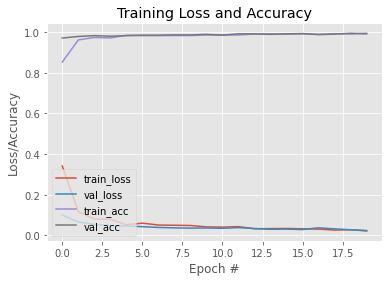

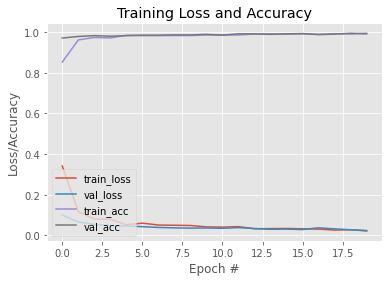

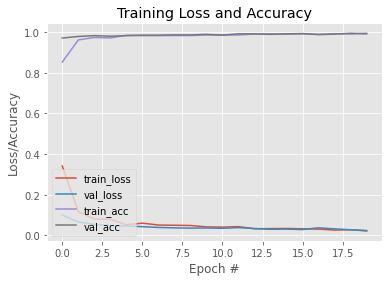

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot)
